In [ ]:
import pandas as pd
df = pd.read_csv('fake_reviews_dataset.csv')
print(df.head())

df.info()

             category  rating label  \
0  Home_and_Kitchen_5     5.0    CG   
1  Home_and_Kitchen_5     5.0    CG   
2  Home_and_Kitchen_5     5.0    CG   
3  Home_and_Kitchen_5     1.0    CG   
4  Home_and_Kitchen_5     5.0    CG   

                                               text_  
0  Love this!  Well made, sturdy, and very comfor...  
1  love it, a great upgrade from the original.  I...  
2  This pillow saved my back. I love the look and...  
3  Missing information on how to use it, but it i...  
4  Very nice set. Good quality. We have had the s...  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   category  40432 non-null  object 
 1   rating    40432 non-null  float64
 2   label     40432 non-null  object 
 3   text_     40432 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.2+ MB


# Setup

In [3]:
import pandas as pd
import numpy as np
import re
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

TEXT_COL = 'text_'
CATEGORY_COL = 'category'
LABEL_COL = 'label'

df = pd.read_csv('fake_reviews_dataset.csv')

df = df.dropna(subset=[TEXT_COL])

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

print(f"Cleaning {len(df)} rows...")
df['cleaned_text'] = df[TEXT_COL].apply(clean_text)

# VECTORIZATION
print("Vectorizing data with larger vocabulary...")

tfidf = TfidfVectorizer(max_features=15000, stop_words='english')

X = tfidf.fit_transform(df['cleaned_text']).toarray()
X_tensor = torch.FloatTensor(X)

print("Setup Complete. Data shape:", X_tensor.shape)

Using device: cuda
Cleaning 40432 rows...
Vectorizing data with larger vocabulary...
Setup Complete. Data shape: torch.Size([40432, 15000])


# Task 1 Product Category Classification

In [4]:
# 1. Prepare Target Labels
le_cat = LabelEncoder()
y_cat = le_cat.fit_transform(df[CATEGORY_COL])
num_classes = len(le_cat.classes_)
print(f"Number of categories: {num_classes}")

# Split Data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_cat, test_size=0.2, random_state=42)

y_train_tensor = torch.LongTensor(y_train).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)
X_train = X_train.to(device)
X_test = X_test.to(device)

# Neural Network Architecture
class ProductClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(ProductClassifier, self).__init__()
        # Layer 1: Input (15000) -> 512 neurons
        self.layer1 = nn.Linear(input_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)

        # Layer 2: 512 -> 128 neurons
        self.layer2 = nn.Linear(512, 128)
        self.bn2 = nn.BatchNorm1d(128)

        # Layer 3: Output -> num_classes
        self.layer3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.layer2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.layer3(x)
        return x

# 3. Initialize Model & Optimizer
input_dim = X_tensor.shape[1] # 15000
model_cat = ProductClassifier(input_dim, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cat.parameters(), lr=0.001)

# 4. Training Loop
epochs = 15
batch_size = 64
print(f"Training Task 1 Model on {device}...")

train_data = torch.utils.data.TensorDataset(X_train, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    model_cat.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model_cat(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Average Loss: {total_loss/len(train_loader):.4f}')

# 5. Evaluation
print("\nEvaluating Task 1...")
model_cat.eval()
with torch.no_grad():
    outputs = model_cat(X_test)
    _, predicted = torch.max(outputs.data, 1)

    y_true = y_test_tensor.cpu().numpy()
    y_pred = predicted.cpu().numpy()

    acc = accuracy_score(y_true, y_pred)
    print(f"Task 1 Accuracy: {acc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=le_cat.classes_))

Number of categories: 10
Training Task 1 Model on cuda...
Epoch [5/15], Average Loss: 0.1321
Epoch [10/15], Average Loss: 0.0663
Epoch [15/15], Average Loss: 0.0454

Evaluating Task 1...
Task 1 Accuracy: 0.7486

Classification Report:
                              precision    recall  f1-score   support

                     Books_5       0.71      0.70      0.70       915
Clothing_Shoes_and_Jewelry_5       0.78      0.78      0.78       746
               Electronics_5       0.76      0.78      0.77       760
          Home_and_Kitchen_5       0.66      0.70      0.68       847
              Kindle_Store_5       0.76      0.76      0.76       971
             Movies_and_TV_5       0.88      0.84      0.86       735
              Pet_Supplies_5       0.88      0.83      0.85       867
       Sports_and_Outdoors_5       0.64      0.60      0.62       802
Tools_and_Home_Improvement_5       0.67      0.72      0.70       711
            Toys_and_Games_5       0.77      0.79      0.78     

# Task 2 Fake Review Detection

In [5]:
# 1. Prepare Target Labels (CG/OR -> 0/1)
le_fake = LabelEncoder()
y_fake = le_fake.fit_transform(df[LABEL_COL])

print(f"Label Mapping: {dict(zip(le_fake.classes_, le_fake.transform(le_fake.classes_)))}")

# Split Data
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_tensor, y_fake, test_size=0.2, random_state=42)

y_train_tensor_f = torch.FloatTensor(y_train_f).unsqueeze(1).to(device)
y_test_tensor_f = torch.FloatTensor(y_test_f).unsqueeze(1).to(device)
X_train_f = X_train_f.to(device)
X_test_f = X_test_f.to(device)

# 2. Define Binary Network
class FakeReviewClassifier(nn.Module):
    def __init__(self, input_dim):
        super(FakeReviewClassifier, self).__init__()
        # Simpler architecture for binary classification
        self.layer1 = nn.Linear(input_dim, 256)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.layer2 = nn.Linear(256, 64)
        self.layer3 = nn.Linear(64, 1) # Single output neuron
        self.sigmoid = nn.Sigmoid()    # Squashes output between 0 and 1

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.layer3(x)
        x = self.sigmoid(x)
        return x

# 3. Initialize & Train
model_fake = FakeReviewClassifier(input_dim).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model_fake.parameters(), lr=0.0001)

print(f"Training Task 2 Model on {device}...")
train_data_f = torch.utils.data.TensorDataset(X_train_f, y_train_tensor_f)
train_loader_f = torch.utils.data.DataLoader(train_data_f, batch_size=64, shuffle=True)

for epoch in range(15):
    model_fake.train()
    total_loss = 0
    for batch_X, batch_y in train_loader_f:
        optimizer.zero_grad()
        outputs = model_fake(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/15], Loss: {total_loss/len(train_loader_f):.4f}')

# 4. Evaluate
print("\nEvaluating Task 2...")
model_fake.eval()
with torch.no_grad():
    outputs = model_fake(X_test_f)
    predicted = (outputs > 0.5).float()

    y_true_f = y_test_tensor_f.cpu().numpy()
    y_pred_f = predicted.cpu().numpy()

    acc = accuracy_score(y_true_f, y_pred_f)
    print(f"Task 2 Accuracy: {acc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true_f, y_pred_f, target_names=le_fake.classes_))

print("\n Which Category is Easiest to Detect?")

_, X_test_f, _, y_test_f, _, cat_test = train_test_split(
    X_tensor, y_fake, df[CATEGORY_COL], test_size=0.2, random_state=42
)
model_fake.eval()
with torch.no_grad():
    outputs = model_fake(X_test_f.to(device))
    predicted = (outputs > 0.5).float().cpu().numpy().flatten()

results_df = pd.DataFrame({
    'Category': cat_test.values,
    'True_Label': y_test_f,
    'Predicted_Label': predicted
})

cat_acc = results_df.groupby('Category').apply(
    lambda x: accuracy_score(x['True_Label'], x['Predicted_Label'])
)

print(cat_acc.sort_values(ascending=False))

Label Mapping: {'CG': np.int64(0), 'OR': np.int64(1)}
Training Task 2 Model on cuda...
Epoch [5/15], Loss: 0.1952
Epoch [10/15], Loss: 0.1398
Epoch [15/15], Loss: 0.1034

Evaluating Task 2...
Task 2 Accuracy: 0.8713

Classification Report:
              precision    recall  f1-score   support

          CG       0.87      0.87      0.87      4016
          OR       0.87      0.87      0.87      4071

    accuracy                           0.87      8087
   macro avg       0.87      0.87      0.87      8087
weighted avg       0.87      0.87      0.87      8087


 Which Category is Easiest to Detect?
Category
Tools_and_Home_Improvement_5    0.897328
Kindle_Store_5                  0.895984
Pet_Supplies_5                  0.881200
Sports_and_Outdoors_5           0.877805
Toys_and_Games_5                0.869031
Electronics_5                   0.868421
Books_5                         0.864481
Movies_and_TV_5                 0.857143
Clothing_Shoes_and_Jewelry_5    0.852547
Home_and_Kitchen

/tmp/ipython-input-619003352.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cat_acc = results_df.groupby('Category').apply(


# Task 3 Word Cloud Generation

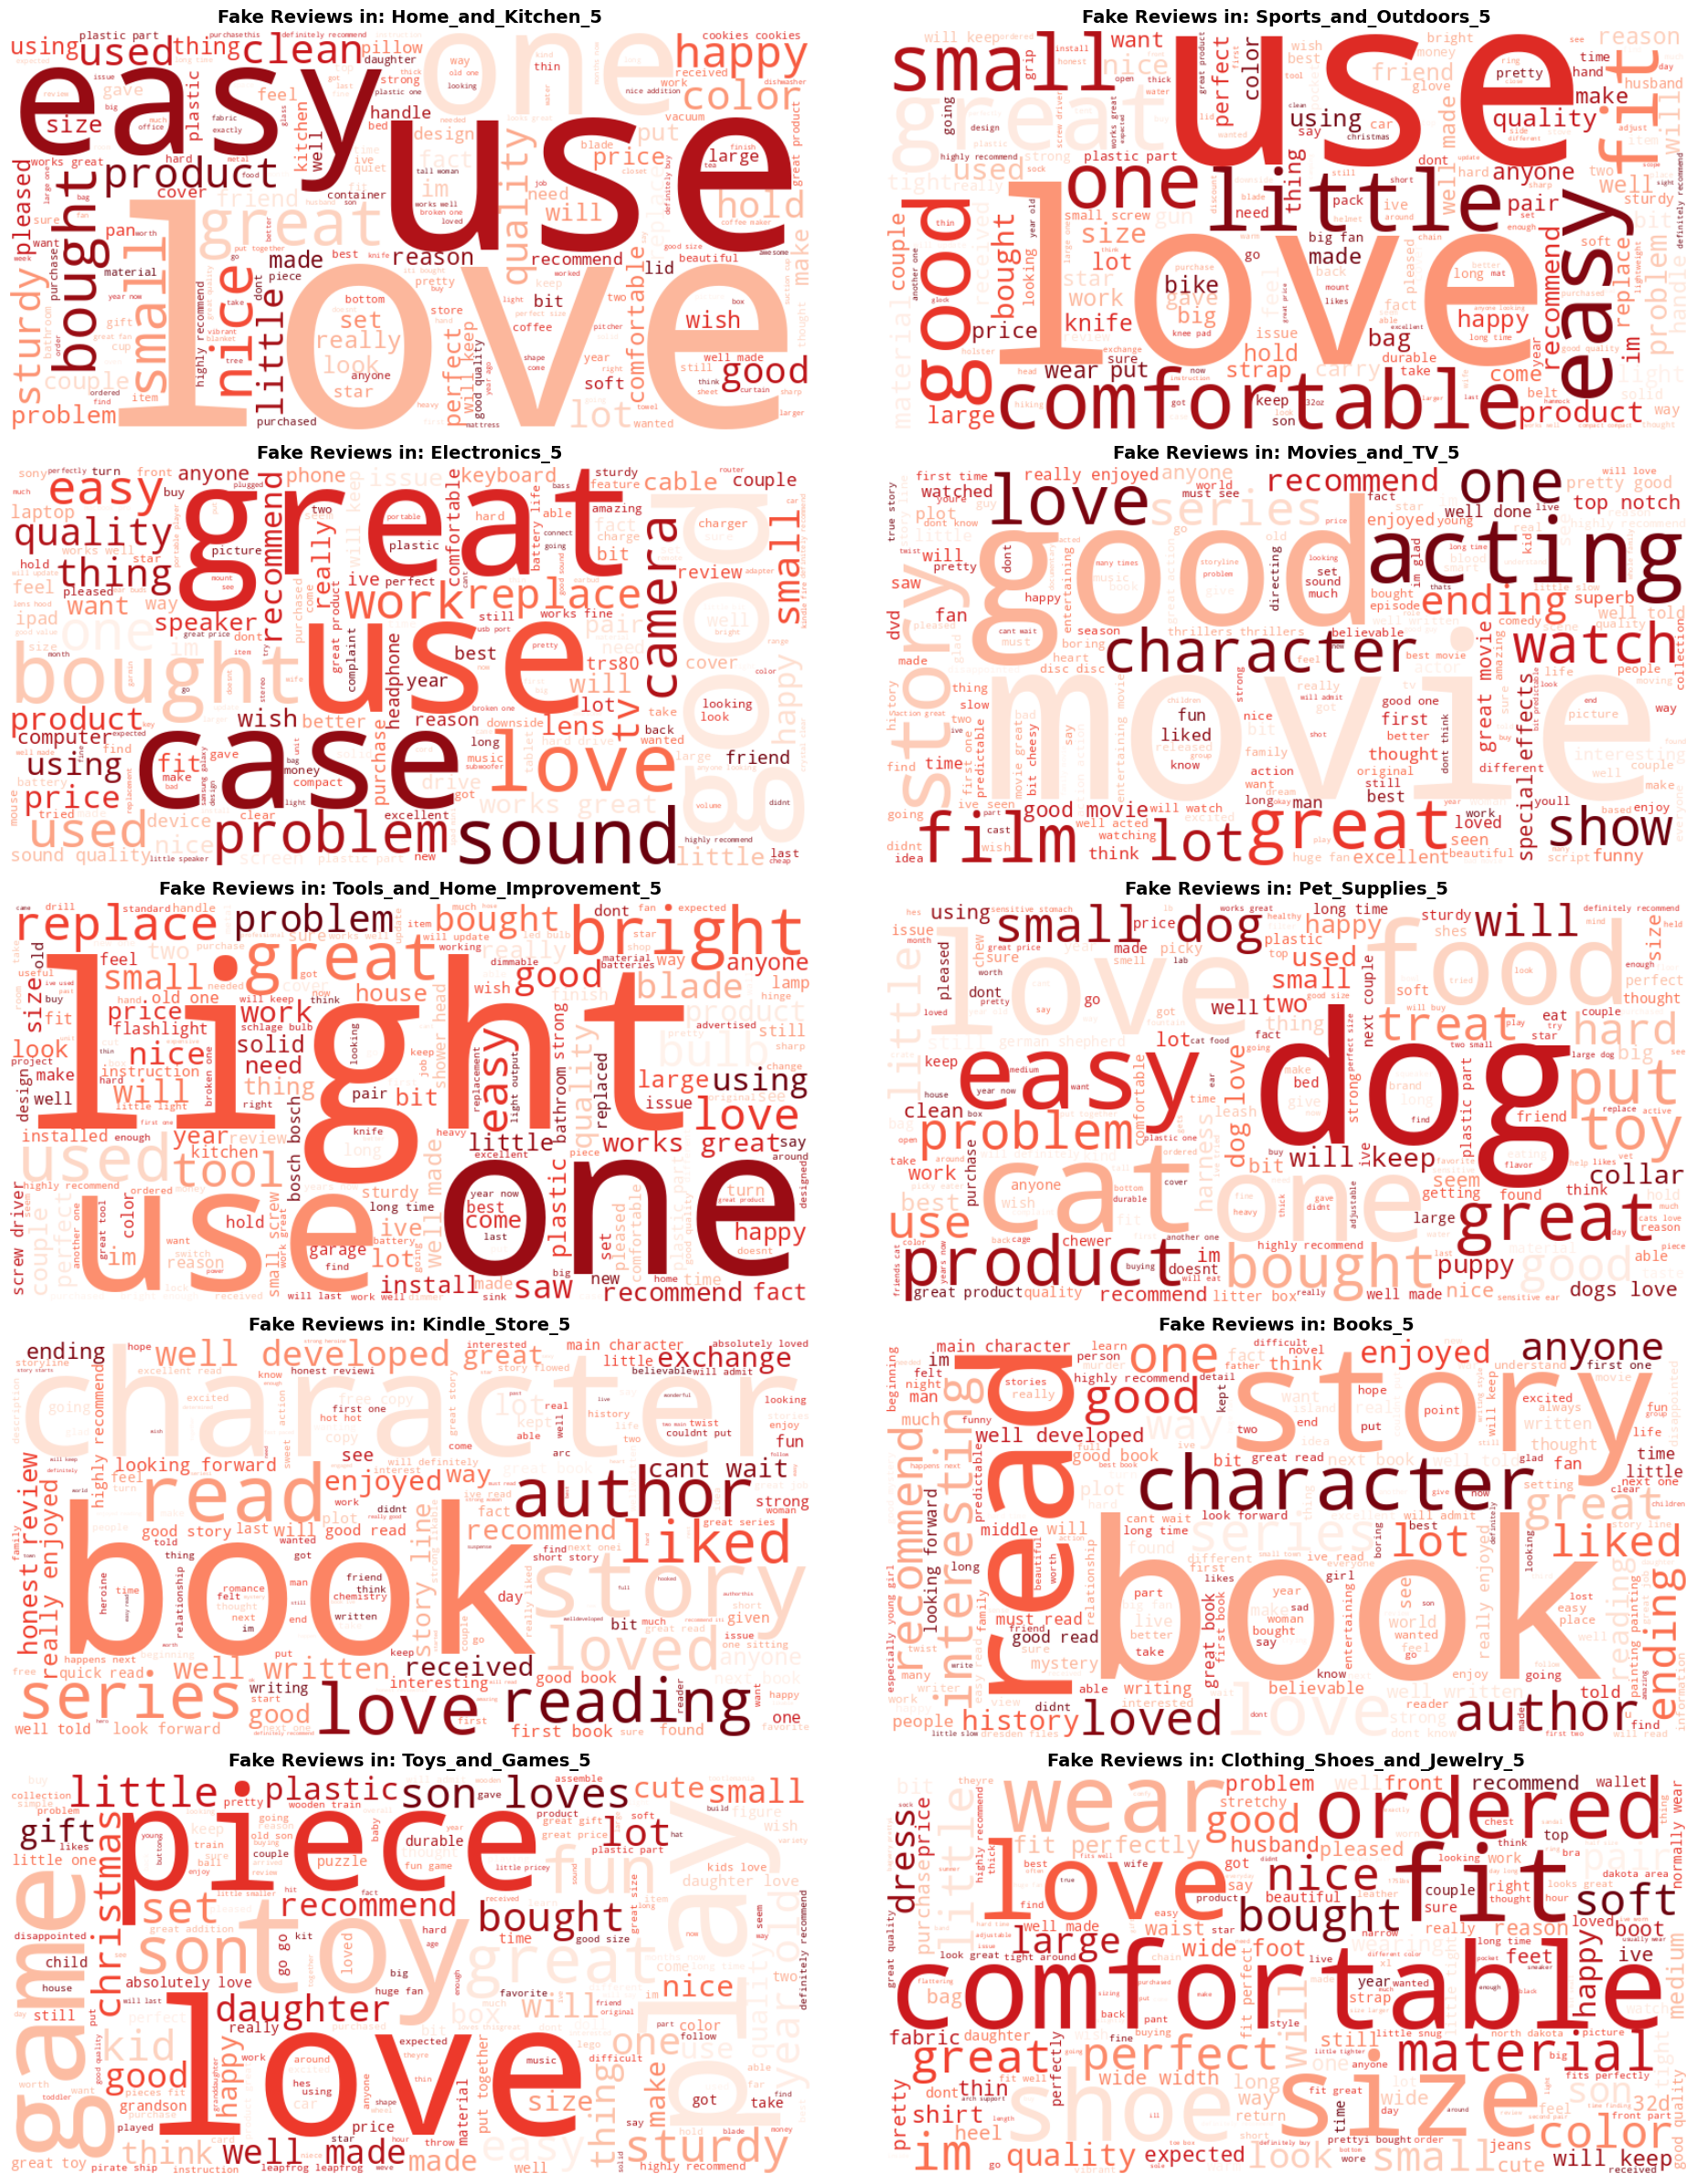

In [8]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import math

categories = df[CATEGORY_COL].unique()

rows = math.ceil(len(categories) / 2)
fig, axes = plt.subplots(rows, 2, figsize=(20, 24))
axes = axes.flatten()

for i, cat in enumerate(categories):
    ax = axes[i]

    # Get only Fake (CG) reviews for 'this' category
    subset = df[(df[CATEGORY_COL] == cat) & (df[LABEL_COL] == 'CG')]

    # Combine text
    text_combined = " ".join(subset['cleaned_text'].astype(str))

    if len(text_combined) > 0:
        wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(text_combined)

        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(f"Fake Reviews in: {cat}", fontsize=14, fontweight='bold')
        ax.axis('off')
    else:
        ax.text(0.5, 0.5, "No Fake Reviews Found", ha='center', va='center')
        ax.axis('off')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()